# 单层SNN识别MNIST

作者: [赵振宇](https://github.com/15947470421)

感谢朱文凯为本教程提供的建议

本节教程将介绍如何使用编码器与替代梯度方法训练一个十分简单的MNIST分类网络。

本节使用的训练代码也将作为一个通用模板，在接下来的课程中，我们代码的架构还会沿用本节的代码，只针对部分代码进行修改

首先我们引入需要使用的库

`torchsummary`是一个用于预览网络规模以及参数量的库，可以在当前的anaconda环境的命令行环境中使用`pip install torchsummary`安装

In [15]:
# import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import numpy as np
from torchsummary import summary # 用于预览神经网络结构的库
from spikingjelly.activation_based import neuron, encoding, functional, surrogate
from spikingjelly import visualizing
from matplotlib import pyplot as plt
import time

首先我们进行一些基本配置，包括配置运行硬件平台，指定数据集地址等

注意，这里需要我们手动建立对应的文件夹目录。`./`表示当前jupyter notebook文件所在的地址

最终，路径中应该类似如下结构：
+ dataset
+ model_save

  ++ auto_save

  ++ history_save
  
+ 当前jupyter notebook代码

In [16]:
# 配置基本信息
# 配置运行硬件平台
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
# 指定数据集地址
dataset_dir = "./dataset" # 数据集地址
# 指定数据集的batch_size
batch_size = 64
# 设定自动保存模型的地址 
# 请务必确保已经建立文件夹
model_auto_save_dir = "./model_save/auto_save/"
# 设定手动保存模型的地址 
# 请务必确保已经建立文件夹
model_history_save_dir = "./model_save/history_save/"
# 设定外部图片地址
# 请务必确保对应文件夹中有该图片，若无外部图片请注释掉该行代码
# img_path = "./dataset/images1.jpg"
# jupyter输出不打印省略号，网络参数过多时不建议开启
# torch.set_printoptions(threshold=np.inf)

device: cuda:0


完成基本的配置后，我们来导入MNIST数据集

In [17]:
# 导入数据集

# 加载训练数据集
train_dataset = torchvision.datasets.MNIST(
    root=dataset_dir,
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)
# 加载测试数据集
test_dataset = torchvision.datasets.MNIST(
    root=dataset_dir,
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)
# 打印训练数据集长度
train_dataset_size = len(train_dataset)
print(f"训练集大小：{train_dataset_size}")
# 打印测试数据集长度
test_dataset_size = len(test_dataset)
print(f"测试集大小：{test_dataset_size}")

# 使用DataLoader加载训练数据
train_dataloader = data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)
# 使用DataLoader加载测试数据
test_dataloader = data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

训练集大小：60000
测试集大小：10000


然后，我们定义我们的脉冲神经网络架构，最后我们通过`summary`函数来查看网络架构

网络架构很简单，首先将28 * 28的MNIST数据通过`flatten`层展开，然后通过一个全连接`linear_1`层实现权重累加，最后将结果输入到10输出的LIF神经元`lif_layer_1`层
+ flatten()
+ linear(in_features=28 * 28, out_features=10, bias=False)
+ lif(tau=2.0, surrogate_function=surrogate.ATan())

In [18]:
# 定义网络架构
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(in_features=28 * 28, out_features=10, bias=False)
        self.lif_layer_1 = neuron.LIFNode(tau=2.0, surrogate_function=surrogate.ATan())

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.lif_layer_1(x)
        # x = F.softmax(x, dim=0) # softmax激活层用于多元分类
        return x
    
# 实例化神经网络
net = SNN()
net = net.to(device) # 将神经网络转换

# 打印神经网络信息
print("神经网络信息")
print(net)

# 测试神经网络的输出格式
# 设置满足要求的输入
input = torch.ones([1, 1, 28, 28])
input = input.to(device)
print("输入数据格式", input.shape)

output = net(input)
print("输出数据格式", output.shape)

# 查看神经网络模型大小
summary(net, input_size=[[1, 28, 28]])

# 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的
functional.reset_net(net)

神经网络信息
SNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=784, out_features=10, bias=False)
  (lif_layer_1): LIFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch, tau=2.0
    (surrogate_function): ATan(alpha=2.0, spiking=True)
  )
)
输入数据格式 torch.Size([1, 1, 28, 28])
输出数据格式 torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,840
              ATan-3                   [-1, 10]               0
           LIFNode-4                   [-1, 10]               0
Total params: 7,840
Trainable params: 7,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
---

定义训练神经网络的超参数，这里我们使用Adam作为优化器，设置数据编码器为泊松编码器`encoding.PoissonEncoder()`，设置仿真周期T为20

In [19]:
# 设置神经网络超参数
# 设置损失函数
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device) # 将损失函数转换

# 设置优化器
learning_rate = 0.001 # 设置学习率
lambda_val = 0.0 # 设置正则化系数Lambda
optim = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=lambda_val)

# 定义输入数据编码器
encoder = encoding.PoissonEncoder()

# 设定仿真时长T
T = 20

设定训练轮数`epoch`以及定义训练过程中所需的临时参数

In [20]:
# 设定训练轮数
epoch = 5
# 定义训练集loss以及准确率变量
loss_train = 0.0 # 训练损失值
loss_train_sum = 0.0 # 训练损失值累加值
loss_train_mean = 0.0 # 这一轮训练损失值的平均值
loss_train_store = np.zeros(epoch) # 训练损失值存储数组
accuracy_train = 0 # 训练准确数
accuracy_rate_train = 0.0 # 训练准确率
accuracy_rate_train_max = 0.0 # 最大训练准确率
accuracy_rate_train_store = np.zeros(epoch) # 训练准确率存储素数组
# 定义交叉验证集loss以及准确率变量
loss_cv = 0.0 # 验证损失值
loss_cv_sum = 0.0 # 验证损失值累加值
loss_cv_mean = 0.0 # 这一轮验证损失值的平均值
loss_cv_store = np.zeros(epoch) # 验证损失值存储数组
accuracy_cv = 0 # 验证准确数
accuracy_rate_cv = 0.0 # 验证准确率
accuracy_rate_cv_max = 0.0 # 最大验证准确率
accuracy_rate_cv_store = np.zeros(epoch) # 验证准确率存储素数组

训练网络的主循环代码

这里，我们将标签转化为独热编码，在循环了仿真周期T后，我们需要统计输出层的10个神经元的脉冲发放率，取发放率最高的表示推理结果

In [21]:
# 训练网络

#########################开始训练########################

for i in range(epoch):
    print("-----------第%d轮训练开始------------" %i)
    # 每轮loss累加值清零
    loss_train_sum = 0
    loss_cv_sum = 0
    # 开始训练神经网络
    net.train()
    # 这一轮的训练计数
    train_step = 0
    # 准确性变量清零
    accuracy_train = 0
    for data in train_dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        label_onehot = F.one_hot(labels, 10).float() # 将标签转化为独热编码

        out_fr = 0. # 输出神经元脉冲发放率
        # out_fr是shape=[batch_size, 10]的tensor
        # 记录整个仿真时长内，输出层的10个神经元的脉冲发放率
        for t in range(T):
            encoded_img = encoder(inputs) # 先将输入图像编码为脉冲形式数据
            out_fr += net(encoded_img) # 将输出层的10个神经元的脉冲输出累加
        out_fr = out_fr / T # 除以时间，得到输出层的10个神经元的脉冲发放率
        # 计算损失函数
        loss_train = F.mse_loss(out_fr, label_onehot)
        # 损失函数为输出层神经元的脉冲发放频率，与真实类别的MSE
        # 这样的损失函数会使得：当标签i给定时，输出层中第i个神经元的脉冲发放频率趋近1，而其他神经元的脉冲发放频率趋近0
        # 累加损失函数
        loss_train_sum += loss_train.item()
        # 将分类概率转化为对应标签
        pred_label = out_fr.argmax(1)
        # 累加计算结果准确性
        accuracy_train += (pred_label == labels).sum()
        # 清零优化器的累计梯度
        optim.zero_grad()
        # 计算梯度
        loss_train.backward()
        # 优化器开始优化
        optim.step()
        
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的
        functional.reset_net(net)

    # 计算平均训练集损失函数loss_train
    loss_train_mean = loss_train_sum / (train_dataset_size/batch_size)
    loss_train_store[i] = loss_train_mean # 将loss记录，方便后续输出loss曲线
    # 计算训练集准确率
    accuracy_rate_train = (accuracy_train/train_dataset_size) * 100
    accuracy_rate_train_store[i] = accuracy_rate_train


    # 开始测试神经网络
    net.eval()
    # 这一轮的测试计数
    test_step = 0
    # 准确性变量清零
    accuracy_cv = 0
    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            label_onehot = F.one_hot(labels, 10).float()
            out_fr = 0.0
            for t in range(T):
                encoded_img = encoder(inputs)
                # 输入神经网络并运行
                out_fr += net(encoded_img)
            out_fr = out_fr / T
            # 计算损失函数
            loss_cv = F.mse_loss(out_fr, label_onehot)
            # 累加损失函数
            loss_cv_sum += loss_cv.item()
            # 将分类概率转化为对应标签
            pred_label = out_fr.argmax(1)
            # 累加计算结果准确性
            accuracy_cv += (pred_label == labels).sum()
            test_step += 1
            # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的
            functional.reset_net(net)

        # 计算交叉验证集损失函数loss cv
        loss_cv_mean = loss_cv_sum / (test_dataset_size/batch_size)
        loss_cv_store[i] = loss_cv_mean # 将loss记录，方便后续输出loss曲线
        # 计算交叉验证集准确率
        accuracy_rate_cv = (accuracy_cv/test_dataset_size) * 100
        accuracy_rate_cv_store[i] = accuracy_rate_cv

    # 输出该轮训练结果
    print(f"loss train: {loss_train_mean: .4f}, accuracy rate train: {accuracy_rate_train.item(): .4f}%, loss cv: {loss_cv_mean: .4f}, accuracy rate cv: {accuracy_rate_cv.item(): .4f}%")
    # 自动保存训练过程中准确率大于之前的神经网络模型
    if (accuracy_rate_train + accuracy_rate_cv > accuracy_rate_train_max + accuracy_rate_cv_max):
        torch.save(net, model_auto_save_dir + "model_auto_save_acc%d.pth" %accuracy_rate_cv)
        accuracy_rate_train_max = accuracy_rate_train # 记录最大训练准确率
        accuracy_rate_cv_max = accuracy_rate_cv # 记录最大训练准确率
    
#########################结束训练########################
print("-------------------------------训练完成-------------------------------")

-----------第0轮训练开始------------
loss train:  0.0276, accuracy rate train:  86.3050%, loss cv:  0.0196, accuracy rate cv:  91.1800%
-----------第1轮训练开始------------
loss train:  0.0190, accuracy rate train:  90.7500%, loss cv:  0.0178, accuracy rate cv:  91.5300%
-----------第2轮训练开始------------
loss train:  0.0177, accuracy rate train:  91.3367%, loss cv:  0.0169, accuracy rate cv:  91.8400%
-----------第3轮训练开始------------
loss train:  0.0170, accuracy rate train:  91.6000%, loss cv:  0.0167, accuracy rate cv:  91.5900%
-----------第4轮训练开始------------
loss train:  0.0167, accuracy rate train:  91.7750%, loss cv:  0.0164, accuracy rate cv:  92.0200%
-------------------------------训练完成-------------------------------


---------损失函数Loss随训练轮数epoch的变化图像---------


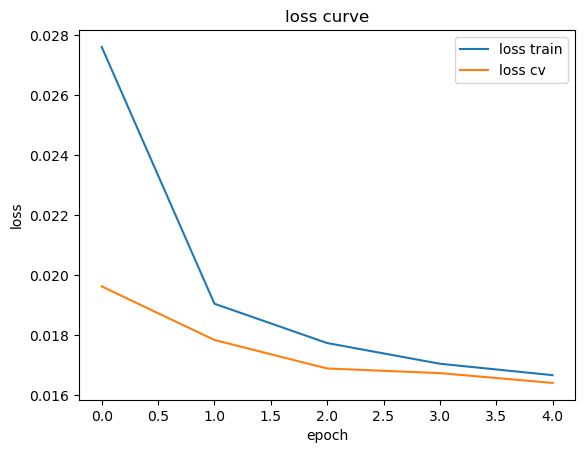

---------准确率accuracy随训练轮数epoch的变化图像---------


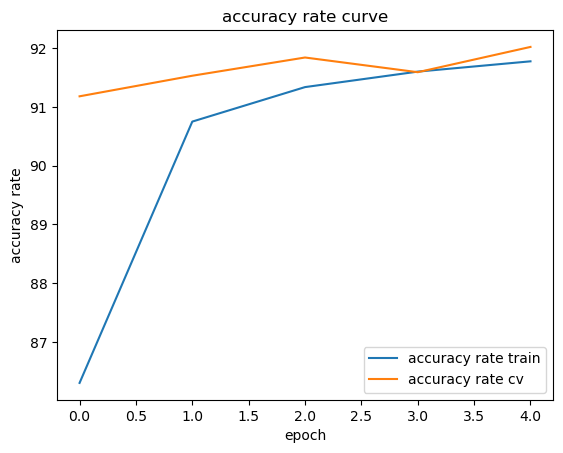

In [22]:
# 画出loss曲线
print("---------损失函数Loss随训练轮数epoch的变化图像---------")
plt.plot(np.arange(epoch), loss_train_store, np.arange(epoch), loss_cv_store)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["loss train", "loss cv"])
plt.title("loss curve")
plt.show()

# 画出accuracy曲线
print("---------准确率accuracy随训练轮数epoch的变化图像---------")
plt.plot(np.arange(epoch), accuracy_rate_train_store, np.arange(epoch), accuracy_rate_cv_store)
plt.xlabel("epoch")
plt.ylabel("accuracy rate")
plt.legend(["accuracy rate train", "accuracy rate cv"])
plt.title("accuracy rate curve")
plt.show()

下面，让我们单独运行推理过程，每100次输出结果

In [23]:
# 加载某一轮训练的模型进行预测
# net = torch.load("model_save/auto_save/model_auto_save_acc95.pth")
# net = torch.load("module_save/history_save/module_save_acc63.pth")

# 开始使用神经网络预测
net.eval()
# 总测试次数
test_step = 0
# 统计准确性
accuracy = 0
with torch.no_grad(): # 预测阶段不进行梯度下降
    for data in test_dataloader:
        inputs, labels = data
        inputs = inputs.to(device) # 将数据转换
        labels = labels.to(device) # 将数据转换
        label_onehot = F.one_hot(labels, 10).float()
        out_fr = 0.0
        for t in range(T):
            encoded_img = encoder(inputs)
            out_fr += net(encoded_img)
        out_fr = out_fr / T
        # 将分类概率转化为对应标签
        pred_label = out_fr.argmax(1)
        # 每100次输出结果
        if (test_step%100==0):
            print("输出结果", pred_label)
            print("原始标签", labels)
        # 累加计算结果准确性
        accuracy += (pred_label == labels).sum()
        test_step += 1

        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的
        functional.reset_net(net)

accuracy_rate = accuracy/test_dataset_size
print("模型预测正确数", accuracy.item(), "模型测试总数", test_dataset_size)
print("模型预测准确率: %.2f%%" %(accuracy_rate.item()*100))

输出结果 tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 0, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 3, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 2], device='cuda:0')
原始标签 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0')
输出结果 tensor([0, 9, 6, 8, 8, 5, 6, 1, 1, 9, 8, 9, 2, 3, 5, 5, 9, 4, 2, 1, 9, 2, 9, 2,
        0, 2, 6, 4, 0, 0, 1, 2, 8, 4, 4, 8, 9, 0, 1, 2, 3, 7, 8, 9, 0, 1, 2, 3,
        4, 7, 8, 9, 7, 3, 0, 3, 1, 8, 7, 6, 4, 0, 2, 6], device='cuda:0')
原始标签 tensor([0, 9, 6, 8, 8, 5, 6, 1, 1, 9, 8, 9, 2, 3, 5, 5, 9, 4, 2, 1, 9, 3, 9, 2,
        0, 6, 0, 4, 0, 0, 1, 2, 3, 4, 7, 8, 9, 0, 1, 2, 3, 7, 8, 9, 0, 1, 2, 3,
        4, 7, 8, 9, 7, 3, 0, 3, 1, 8, 7, 6, 4, 0, 2, 6], device='cuda:0')
模型预测正确数 9181 模型测试总数 10000
模型预测准确率: 91.81%


为了更直观的感受，我们可以选择取出单张图片进行预测，通过更改`index`可以选择不同的输入图像

想要在此时获取输出层神经元的膜电位，是有一些难度的，需要我们使用“钩子”hook功能。

原始图像
label: 0


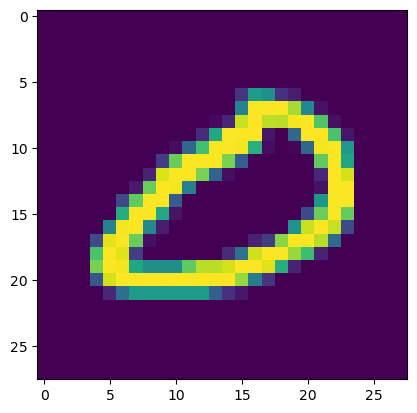

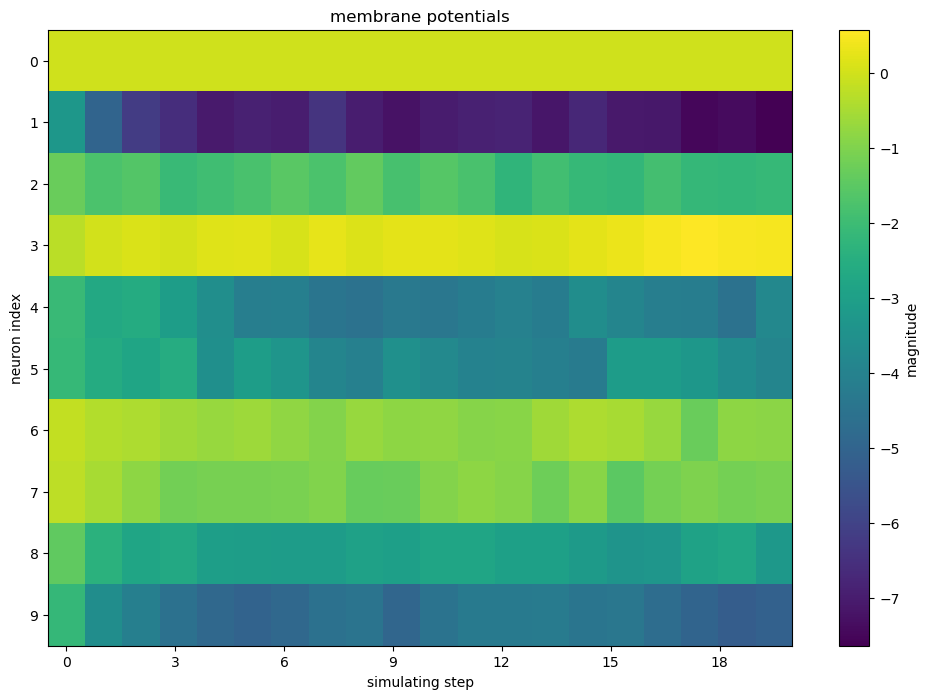

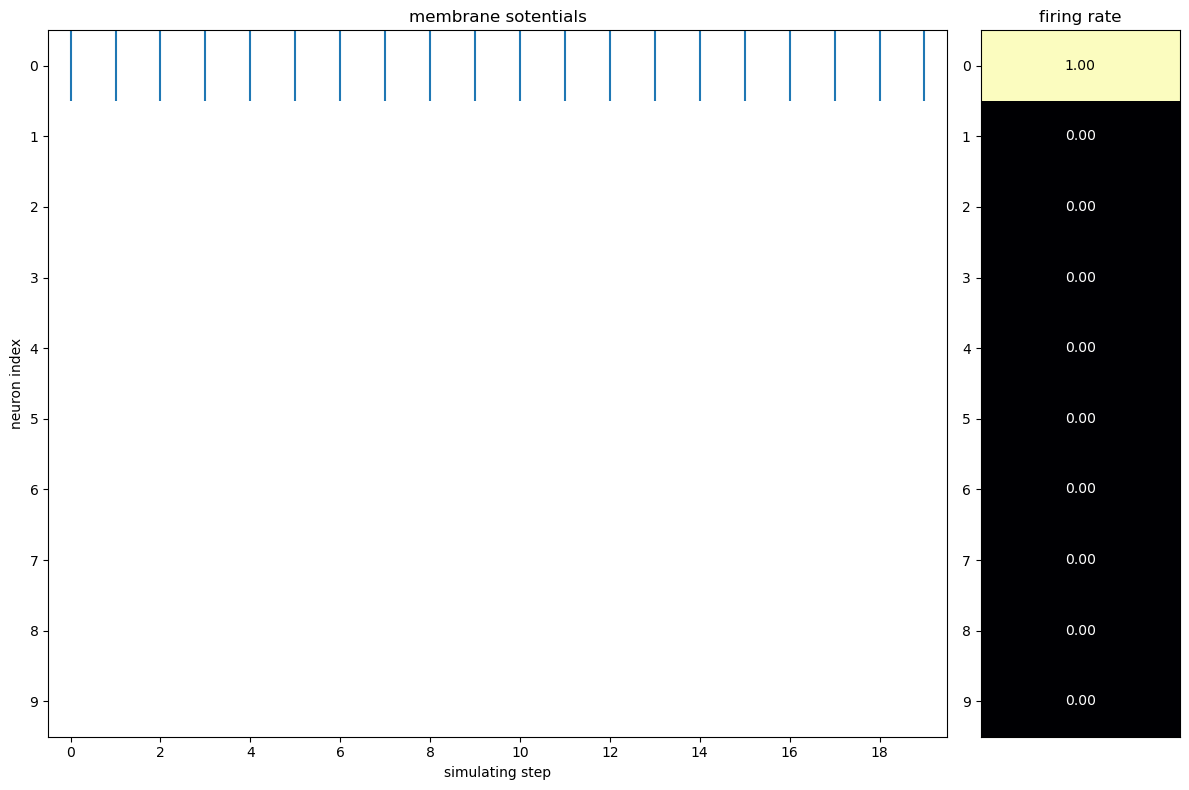

In [24]:
# 取出单张图片进行预测

# 载入原始数据
# 加载测试集中的单张图片
# 保存绘图用数据
net.eval()
# 注册钩子
output_layer = net.lif_layer_1 # 输出层
output_layer.v_seq = []
output_layer.s_seq = []
def save_hook(m, x, y):
    m.v_seq.append(m.v.unsqueeze(0))
    m.s_seq.append(y.unsqueeze(0))

hook = output_layer.register_forward_hook(save_hook)

# 加载测试集中的单张图片
index = 8373
input, label = test_dataset[index]
input = torchvision.transforms.ToPILImage()(input)
plt.imshow(input)
print("原始图像")
print(f"label: {label}")
plt.show()

# 开始使用神经网络预测
net.eval()
with torch.no_grad():
    img, label = test_dataset[index]
    img = img.to(device)
    out_fr = 0.
    for t in range(T):
        encoded_img = encoder(img)
        out_fr += net(encoded_img)
    out_spikes_counter_frequency = (out_fr / T).cpu().numpy()

    output_layer.v_seq = torch.cat(output_layer.v_seq)
    output_layer.s_seq = torch.cat(output_layer.s_seq)
    v_t_array = output_layer.v_seq.cpu().numpy().squeeze()  # v_t_array[i][j]表示神经元i在j时刻的电压值
    s_t_array = output_layer.s_seq.cpu().numpy().squeeze()  # s_t_array[i][j]表示神经元i在j时刻释放的脉冲，为0或1

    # 膜电位热力图和输出脉冲结果
    figsize = (12, 8)
    dpi = 100
    visualizing.plot_2d_heatmap(array=v_t_array, title='membrane potentials', xlabel='simulating step',
                                ylabel='neuron index', int_x_ticks=True, x_max=T, figsize=figsize, dpi=dpi)


    visualizing.plot_1d_spikes(spikes=s_t_array, title='membrane sotentials', xlabel='simulating step',
                            ylabel='neuron index', figsize=figsize, dpi=dpi)

    plt.show()

hook.remove()

In [25]:
# 保存神经网络模型
# torch.save(net, model_history_save_dir + "module_save_acc.pth")
# print("模型已保存")

In [26]:
# 查看网络参数
print(net)
net.named_parameters()
for name, param in net.named_parameters(prefix="SNN"):
    print(name, param)
    print(name, param.size())

SNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=784, out_features=10, bias=False)
  (lif_layer_1): LIFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch, tau=2.0
    (surrogate_function): ATan(alpha=2.0, spiking=True)
  )
)
SNN.linear_1.weight Parameter containing:
tensor([[ 9.6435e-03, -9.3254e-03, -1.4973e-03, -4.6127e-03, -3.2445e-03,
          2.3353e-02,  3.4768e-02, -3.1842e-02, -1.1396e-02, -2.7142e-02,
         -3.3329e-03,  2.6733e-02,  1.4400e-02,  2.5748e-02, -3.4509e-02,
          1.5211e-02, -1.0122e-02,  8.1712e-03, -1.7914e-02, -6.2396e-03,
          1.0336e-03,  1.1991e-02,  9.6881e-04, -1.8907e-02, -1.8555e-02,
          1.0539e-03,  3.6112e-03, -9.0087e-03,  6.2795e-04,  1.1167e-02,
          1.0810e-02,  1.3528e-02,  1.9179e-02, -1.4478e-02, -2.6765e-02,
          1.4206e-02,  3.1271e-02,  1.0957e-03, -5.9162e-02,  1.1181e-01,
          1.3387e-01,  9.7106e-02, -1.5293e-02,  2.4963e-04,  4.3792e-

In [27]:
# 清除显存
torch.cuda.empty_cache()